<h1><center><font size="30">Generating DP Synthetic Datasets using GAN</font></center></h1>

## cGAN

Conditional GAN or cGAN is a type of Generative Adversarial Network which adds the label y as an additional parameter to the generator.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

## Seeding with student id:
np.random.seed(20878205)

In [ ]:
class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=32, out_shape=14, epsilon=1.0):

        #####
        ###Generate synthetic dataset with epsilon=1 and epsilon=5
        #####
        self.epsilon = epsilon

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = legacy.Adam(0.0002, 0.5)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        #### Adding layers to the generator
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    ######
    ### Adding controlled noise to synthetic data to further enhance privacy
    ######
    def add_noise_to_gradient(self, grad, sigma):
        """
        Add noise to the gradients for DP.
        """
        noisy_grad = grad + np.random.normal(0, sigma, grad.shape)
        return noisy_grad


    ######
    ### Differential Privacy implemented using Moments Accountant method (Alternatives: PATE method)
    #####
    def moments_accountant(self, num_samples, batch_size, sigma):
        """
        Compute the privacy budget (epsilon) using the Moments Accountant approach.
        """
        q = batch_size / num_samples
        B = (sigma ** 2) * num_samples
        epsilon = np.sqrt(2 * np.log(1.25 / q) * B) / (batch_size * self.epsilon)
        return epsilon



    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        global G_losses
        global D_losses

        G_losses = []
        D_losses = []

        ######
        # Initialize privacy parameters
        ######
        delta = 1e-5  # Target delta, a small constant (e.g., 1e-5) to ensure DP
        num_samples = len(y_train)
        max_grad_norm = 1.0  # Maximum L2 norm for gradient clipping
        total_steps = epochs * (num_samples // batch_size)
        sigma = self.moments_accountant(num_samples, batch_size, max_grad_norm)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # added label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the Discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()


    ######
    ### Generate DP Synthetic dataset with epsilon = 1 and 5
    #####
    def generate_synthetic_data(self, num_samples):
        """
        Generate synthetic data using the trained generator network.
        """
        noise = np.random.normal(0, 1, (num_samples, self.latent_dim))
        sampled_labels = np.random.randint(0, 2, num_samples).reshape(-1, 1)
        gen_samples = self.generator.predict([noise, sampled_labels])
        return gen_samples


# Adult Census Income Dataset

Provided dataset has 15 features including one class that we attempt to predict (income). Dataset contains a lot of categorical features that need some preprocessing before feeding it to our algorithm.

In [ ]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Before employing any algorithms, we will first preprocess some data.

## Preprocessing

With the primary goal for synthetic data generation, we won't go into details with feature analysis and feature engineering. For best possible result with the algorithm, those techniques could be implemented. We will only use label-encoding (one-hot encoding would be a better approach).

In [ ]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital.status','occupation','relationship','race','sex','native.country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


In [ ]:
df.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

### Splitting the dataframe

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('income', 1))
y = df['income'].values


#####
## Test split of 1/3 and Train split of 2/3
#####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

<ipython-input-33-21bccb2fab82>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = scaler.fit_transform(df.drop('income', 1))


### Results with original dataset:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      8151
           1       0.78      0.64      0.70      2595

    accuracy                           0.87     10746
   macro avg       0.84      0.79      0.81     10746
weighted avg       0.86      0.87      0.86     10746



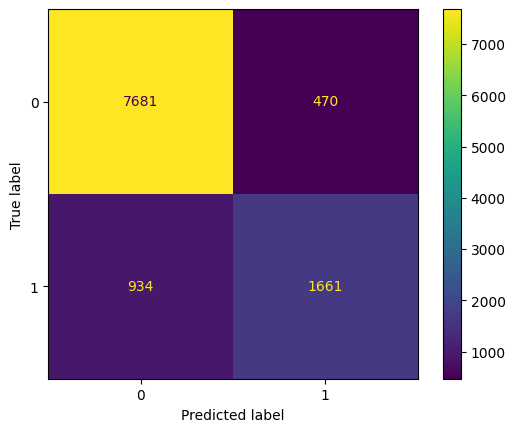

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
# plot_confusion_matrix(lgb_1, X_test, y_test)
# plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', values_format='d')

plt.show()

# Question 2(b): Generating DP Synthetic Datasets:

## DP Synthetic Dataset with Epsilon=1

In [ ]:
#####
## Initializing cGAN model with epsilon=1 (default value)
#####
cgan = cGAN()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
[99/500]	Loss_D: 0.6965	Loss_G: 0.6775
1/1 [==============================] - 0s 27ms/step
[199/500]	Loss_D: 0.6587	Loss_G: 0.6459
1/1 [==============================] - 0s 26ms/step
[299/500]	Loss_D: 0.0738	Loss_G: 1.5163
1/1 [==============================] - 0s 49ms/step
[399/500]	Loss_D: 0.2392	Loss_G: 2.6502
1/1 [==============================] - 0s 38ms/step
[499/500]	Loss_D: 0.1516	Loss_G: 3.1430


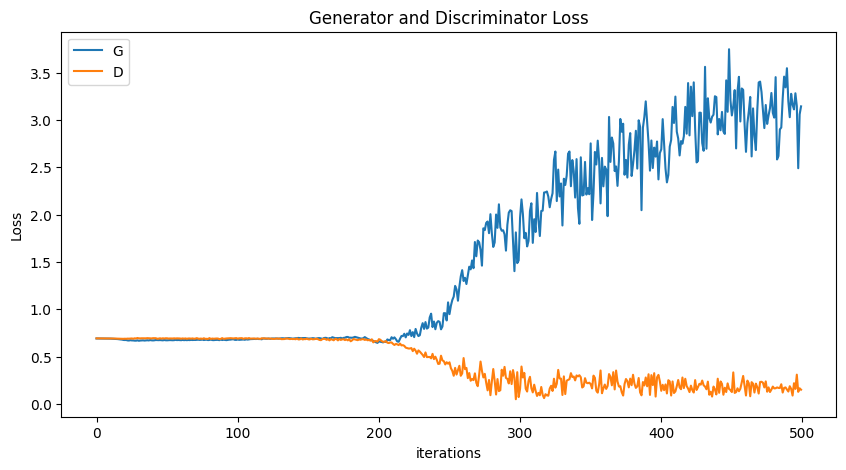

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

### Creating csv file for generated dataset

In [ ]:
gen_samples_0 = cgan.generate_synthetic_data(19758)
gen_samples_1 = cgan.generate_synthetic_data(6290)

gen_df_0 = pd.DataFrame(data=gen_samples_0, columns=df.drop('income', 1).columns)
gen_df_1 = pd.DataFrame(data=gen_samples_1, columns=df.drop('income', 1).columns)

gen_df_0['income'] = 0
gen_df_1['income'] = 1

df_gan_epsilon_1 = pd.concat([gen_df_1, gen_df_0], ignore_index=True, sort=False)
df_gan_epsilon_1 = df_gan_epsilon_1.sample(frac=1).reset_index(drop=True)

# Save the synthetic dataset for ε = 1 to a CSV file
df_gan_epsilon_1.to_csv('synthetic_dataset_epsilon_1.csv', index=False)

197/197 [==============================] - 1s 2ms/step


<ipython-input-37-f8addabb9b9f>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gen_df_0 = pd.DataFrame(data=gen_samples_0, columns=df.drop('income', 1).columns)
<ipython-input-37-f8addabb9b9f>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gen_df_1 = pd.DataFrame(data=gen_samples_1, columns=df.drop('income', 1).columns)


In [ ]:
# Training using dataset with e=1
X_train_2 = df_gan_epsilon_1.drop('income', 1)
y_train_2 = df_gan_epsilon_1['income'].values

<ipython-input-38-b86f878844eb>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_2 = df_gan_epsilon_1.drop('income', 1)


### Results with Synthetic Dataset (Epsilon = 1)

              precision    recall  f1-score   support

           0       0.76      0.97      0.85      8151
           1       0.17      0.02      0.03      2595

    accuracy                           0.74     10746
   macro avg       0.46      0.49      0.44     10746
weighted avg       0.61      0.74      0.65     10746



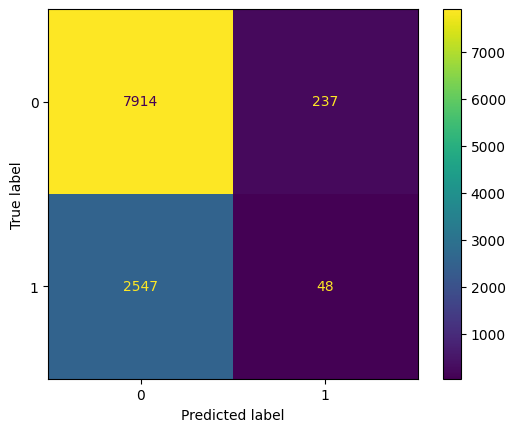

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)

y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
# plot_confusion_matrix(lgb_1, X_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', values_format='d')

plt.show()

## DP Synthetic Dataset with Epsilon = 5

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 24ms/step
[99/500]	Loss_D: 0.6901	Loss_G: 0.6736
1/1 [==============================] - 0s 27ms/step
[199/500]	Loss_D: 0.6814	Loss_G: 0.7301
1/1 [==============================] - 0s 43ms/step
[299/500]	Loss_D: 0.5002	Loss_G: 0.9246
1/1 [==============================] - 0s 27ms/step
[399/500]	Loss_D: 0.5087	Loss_G: 0.7540
1/1 [==============================] - 0s 26ms/step
[499/500]	Loss_D: 0.1332	Loss_G: 2.9765


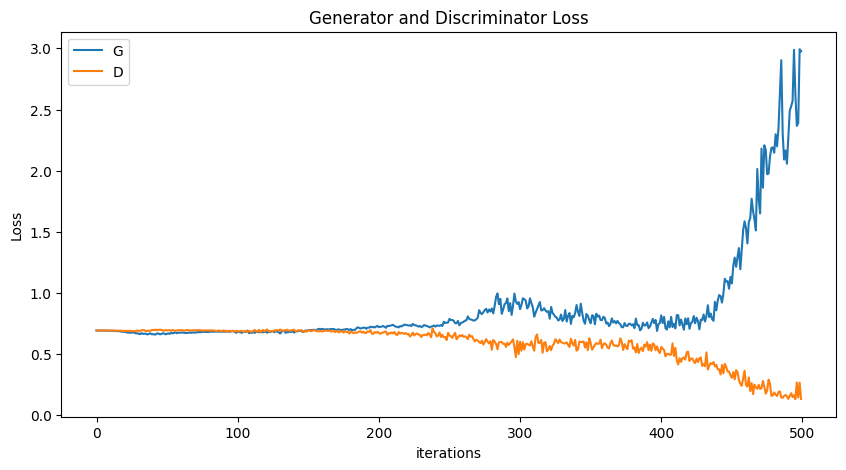

197/197 [==============================] - 1s 2ms/step


<ipython-input-40-5471bf5f4e19>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gen_df_0 = pd.DataFrame(data=gen_samples_0, columns=df.drop('income', 1).columns)
<ipython-input-40-5471bf5f4e19>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  gen_df_1 = pd.DataFrame(data=gen_samples_1, columns=df.drop('income', 1).columns)


In [ ]:
# Now, reinitialize the cGAN and train it with DP for ε = 5

cgan_epsilon_5 = cGAN(epsilon=5.0)
cgan_epsilon_5.train(X_train, y_train, pos_index, neg_index, epochs=500)

gen_samples_0 = cgan_epsilon_5.generate_synthetic_data(19758)
gen_samples_1 = cgan_epsilon_5.generate_synthetic_data(6290)

gen_df_0 = pd.DataFrame(data=gen_samples_0, columns=df.drop('income', 1).columns)
gen_df_1 = pd.DataFrame(data=gen_samples_1, columns=df.drop('income', 1).columns)

gen_df_0['income'] = 0
gen_df_1['income'] = 1

df_gan_epsilon_5 = pd.concat([gen_df_1, gen_df_0], ignore_index=True, sort=False)
df_gan_epsilon_5 = df_gan_epsilon_5.sample(frac=1).reset_index(drop=True)

# Save the synthetic dataset for ε = 5 to a CSV file
df_gan_epsilon_5.to_csv('synthetic_dataset_epsilon_5.csv', index=False)

In [ ]:
X_train_2 = df_gan_epsilon_5.drop('income', 1)
y_train_2 = df_gan_epsilon_5['income'].values

<ipython-input-41-60b62dfacfdf>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_2 = df_gan_epsilon_5.drop('income', 1)


### Results with Epsilon = 5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      8151
           1       0.34      0.01      0.01      2595

    accuracy                           0.76     10746
   macro avg       0.55      0.50      0.44     10746
weighted avg       0.66      0.76      0.66     10746



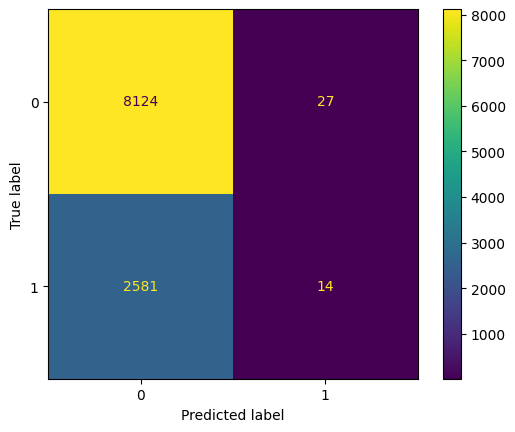

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)

y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
# plot_confusion_matrix(lgb_1, X_test, y_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', values_format='d')

plt.show()
